In [1]:
import numpy as np
import MFI
import exe_plumed
import matplotlib.pyplot as plt
import os
import pickle
import subprocess

In [2]:
path = os.getcwd()
print("The path to this notebook is:", path)

path_data = "/home/antoniu/Desktop/AP_PBC/AP_August_HP"

os.chdir(path)
# try: os.mkdir("AlanineDipeptide_pyMFI")
# except: print("folder \"AlanineDipeptide_pyMFI\" already exists")
# os.chdir("AlanineDipeptide_pyMFI")




The path to this notebook is: /home/antoniu/Desktop/Public_Notebooks/test_potentials


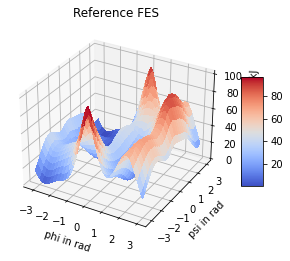

In [3]:
#get reference fes
data = np.genfromtxt('fes_ap_10E9.dat') #np.load('AP_10E9_fes.npy')

FREF=np.reshape(data[:,2],(60,60));
XREF=np.reshape(data[:,0],(60,60));
YREF=np.reshape(data[:,1],(60,60));

FREF = FREF - np.min(FREF)

#Change value of pi. min(XREF) is too small
XREF[XREF == -3.141593] = -np.pi
YREF[YREF == -3.141593] = -np.pi

fes3d = plt.figure(1)
ax = fes3d.gca(projection='3d')
surf = ax.plot_surface(XREF, YREF, FREF, cmap="coolwarm", linewidth=0, antialiased=False)
fes3d.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Reference FES")
ax.set_xlabel('phi in rad')
ax.set_ylabel('psi in rad')
ax.set_zlabel('Free energy in kJ');



In [11]:
# define grid 
nbins = [201, 201] 
min_grid = [-np.pi, -np.pi]
max_grid = [np.pi, np.pi]
grid_space = (max_grid[0] - min_grid[0]) / (nbins[0] - 1)
grid = np.linspace(min_grid[0],max_grid[0],nbins[0])
X, Y = np.meshgrid(grid, grid)
#Use periodic extension for defining PBC
periodic = 1
periodic_extension = 1 / 2
grid_ext = (1/2) * periodic_extension * (max_grid[0]-min_grid[0])
Flim=50


Total no. of Gaussians analysed: 2000
|200/2000|==> Average Mean Force Error: 49.35765713338864
|400/2000|==> Average Mean Force Error: 41.65023099444135
|600/2000|==> Average Mean Force Error: 51.48796690024322
|800/2000|==> Average Mean Force Error: 48.152332593338734
|1000/2000|==> Average Mean Force Error: 48.25692883454099
|1200/2000|==> Average Mean Force Error: 46.395347690174624
|1400/2000|==> Average Mean Force Error: 45.864947061875036
|1600/2000|==> Average Mean Force Error: 29.96391111694401
|1800/2000|==> Average Mean Force Error: 29.037716482299285
|2000/2000|==> Average Mean Force Error: 28.61237005853145


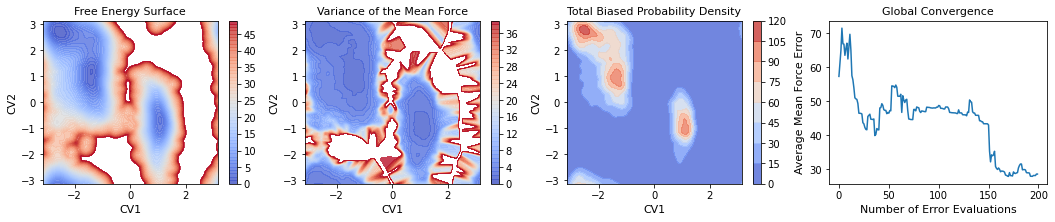

In [9]:
# simulation_steps = 40000000

# #Run Alanine dipeptide simulation
# exe_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49,
#                    grid_min_x="-pi", grid_max_x="pi", grid_min_y="-pi", grid_max_y="pi", grid_bin_x=201,
#                    grid_bin_y=201,
#                    gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=10, gaus_pace=100,
#                    position_pace=0)


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position40")

# Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, min_grid=np.array((-np.pi, -np.pi)), \
           max_grid=np.array((np.pi, np.pi)), nbins=np.array((201, 201)), log_pace = 10, error_pace = 200, WellTempered=1, nhills=2000, periodic=1)

#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)),
                nbins=np.array((201, 201)))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history)



In [6]:
file_name = "Ftot_master_2K.npy"

# # Save Force terms
# Ftot_master = [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y]
# with open(file_name,"wb") as fw:
#     pickle.dump(Ftot_master, fw)
#     pickle.dump(object_save, fw, pickle.HIGHEST_PROTOCOL)
   
#Load Force terms
Ftot_master = []
with open(file_name, "rb") as fr:
    Ftot_master.append(pickle.load(fr))

[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = Ftot_master[0]

In [10]:
#New simulation with harmonic bais
ipos_x = [0.0, -2.5]
ipos_y = [0.0, -1.6]

kappa_x = [100, 0]
kappa_y = [100, 150]

simulation_steps = 100000

#Prepare input files
exe_plumed.find_alanine_dipeptide_input(initial_position_x=ipos_x[0], initial_position_y=ipos_y[0], file_extension="_hp0")

#Run alanine dipeptide simulation
exe_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49,
                   grid_min_x="-pi", grid_max_x="pi", grid_min_y="-pi", grid_max_y="pi", grid_bin_x=201,
                   grid_bin_y=201,
                   gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=10, gaus_pace=100,
                   hp_center_x=ipos_x[0], hp_center_y=ipos_y[0], hp_kappa_x=kappa_x[0], hp_kappa_y=kappa_y[0],
                   lw_center_x=0.0, lw_center_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
                   uw_center_x=0.0, uw_center_y=0.0, uw_kappa_x=0, uw_kappa_y=0,
                   position_pace=0, print_bias = 0,
                   file_extension="_hp0")



Preparing new input files ...
Running Alanine Dipeptide simulation
... Simulation finished.



Total no. of Gaussians analysed: 1000
|100/1000|==> Average Mean Force Error: 25.368993485974933
|200/1000|==> Average Mean Force Error: 18.792752588703934
|300/1000|==> Average Mean Force Error: 22.163524886340422
|400/1000|==> Average Mean Force Error: 25.633803977551274
|500/1000|==> Average Mean Force Error: 23.327233707610716
|600/1000|==> Average Mean Force Error: 26.7596563635068
|700/1000|==> Average Mean Force Error: 21.297515849125237
|800/1000|==> Average Mean Force Error: 19.201440545076483
|900/1000|==> Average Mean Force Error: 20.060173121540558
|1000/1000|==> Average Mean Force Error: 20.777998699250382
shape master (2, 6, 201, 201)


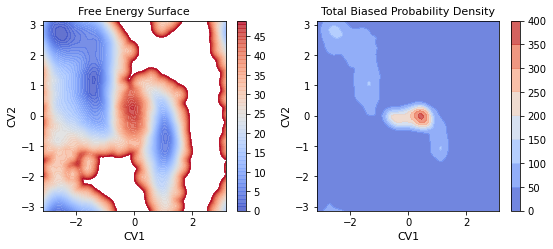

In [11]:
#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path + "/HILLS")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path + "/position")


# Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS=HILLS, position_x=position_x, position_y=position_y, bw=0.1, kT=2.49, \
           min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((201, 201)), \
           log_pace=10, error_pace=200, WellTempered=1, nhills=-1, periodic=1, \
           hp_centre_x=ipos_x[0], hp_centre_y=ipos_y[0], hp_kappa_x=kappa_x[0], hp_kappa_y=kappa_y[0], \
           lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0, \
           uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0)


#save new terms in master list
Ftot_master.append([X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y])


master = [[Ftot_master[0][2], Ftot_master[0][7], Ftot_master[0][3], Ftot_master[0][4], Ftot_master[0][8], Ftot_master[0][9]] , \
[Ftot_master[1][2], Ftot_master[1][7], Ftot_master[1][3], Ftot_master[1][4], Ftot_master[1][8], Ftot_master[1][9]]]

print("shape master", np.shape(master))

#Patch results
[Ftot_x, Ftot_y, Ftot_den, error] = MFI.patch_2D_error(master, nbins=np.array((201, 201)))


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)),
                nbins=np.array((201, 201)))

# Plot Recap
MFI.plot_patch_2D(X, Y, FES, Ftot_den, lim=50)



